# Image Classification: Transfer Learning with ResNet

In this first notebook, we implement the classification of the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), containing 96x96 colour images divided into 10 classes (cats, birds, airplanes, etc.).

We implement here **transfer learning**: we use the Residual Neuronal Newtork ([ResNet](https://arxiv.org/abs/1512.03385)) of *torchvision*, that has been **pre-trained** with the *ImageNet* dataset.

This pre-trained model is built for images that have a size of at least 224x224. Given that we have 96x96 images, we decide to resize them as 224x224 images, and see whether the pre-trained model is adapted to this data or not.

**Remark:**
A first trial on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) 32x32 images dataset gave us bad prediction results (around 40\%). It was probably because the initial images were too small before being resized (and therefore missing some details). Therefore, we try here to use the pre-trained ResNet model on the larger images of the [STL10 dataset](https://cs.stanford.edu/~acoates/stl10/), to see if we get better results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models, utils
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler

We use here the **torchvision** library ([click here for more details](https://pytorch.org/vision/stable/index.html)). This library is part of the Pytorch project, and consists of popular datasets, model architectures, and common image transformations for computer vision.

## Data Augmentation and Preparation for Transfer Learning 

We randomly rotate, flip and crop the input images, in order to introduce some randomness. This will further train our network, and make our predictions more robust to image transformation. 

We also normalize the images to make them fit to the **pre-trained** XXXnet network, and thus implement transfer learning. All pre-trained models of torchvision need to be normalized the same way (with *mean = [0.485, 0.456, 0.406]* and *std = [0.229, 0.224, 0.225]*).

In [2]:
# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 500
# percentage of training set to use as validation
valid_size = 0.2

# We define the transforms for the training data and testing data
# The training data must fit the pre-trained model we will use for Transfer Learning
train_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
    ])

# We load the training and test data
train_data = datasets.STL10('data', split = 'train',
                              download=True, transform=train_transform)
test_data = datasets.STL10('data', split = 'test',
                             download=True, transform=test_transform)

# We choose the indices that will be used to split the training data into train and validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# We define the samplers to choose the training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# We build the data loaders (combining the dataset and the sampler), 
# to get the train, validation, and test data
trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting data/stl10_binary.tar.gz to data
Files already downloaded and verified


We look at a batch of images to see if they have been loaded well.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


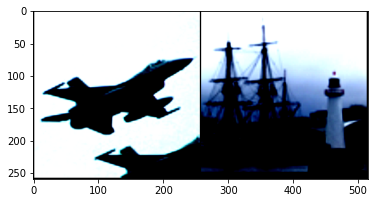

In [3]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from torch to plt image format
    plt.show()

# We get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# We show some images
imshow(utils.make_grid(images[0:2]))

## CNN Implementation (Transfer Learning)

We now implement our neuronal network, that will be divided into **2 parts**.

The first part of our neuronal network is a **pre-trained model**: the [ResNet](https://arxiv.org/abs/1512.03385) model.
This part of our network permits to detect the features of the images thanks to an efficient model that has been already trained on a lot of data.

The second part of our neuronal network is the **classifier**, that takes the output of the ResNet as input, and classifies our images thanks to the observed features.

In [4]:
# We load the pre-trained model
model = models.resnet18(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
# We freeze the parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False
    
# Take the number of features of last layer of the pre-trained model    
n_features = model.fc.in_features
    
# We write our classifier (at the position the last layer of the pre-trained model)
model.fc = nn.Sequential(
    nn.Linear(n_features, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
    )

for param in model.fc.parameters():
    param.requires_grad = True

We use the *Cross Entropy* loss function and the *Adam* optimizer.

In [6]:
# We define the loss criterion
criterion = nn.CrossEntropyLoss()

# Only train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)

# We use GPU if it's available, and the CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);

## Training

We implement the training of our model, with the training and the validation datsets.

In [7]:
# Number of epochs used to train the model
n_epochs = 20

# Variables to keep track of the change in validation loss, to save the best model
valid_loss_min = np.Inf 
best_accuracy = 0.0

# Variables to keep the accuracies calculated at each epoch in order to plot them later
epoch_all = []  
valid_epoch_acc_all = []
train_epoch_acc_all = []

for epoch in range(1, n_epochs+1):

    # To keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    valid_running_corrects = 0
    train_running_corrects = 0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in trainloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        # to calculate the training set accuracy later: 
        # take as prediction the label with highest output (highest probability)
        _, pred = torch.max(output, 1)
        # total number of correct predictions
        train_running_corrects += torch.sum(pred == labels)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in validloader:
        # move tensors to GPU if CUDA is available
        images, labels = images.to(device), labels.to(device)
        # forward pass: compute predicted outputs by passing images to the model
        output = model.forward(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
        # to calculate the validation accuracy later: 
        # take as prediction the label with highest output (highest probability)
        _, pred = torch.max(output, 1)
        # total number of correct predictions
        valid_running_corrects += torch.sum(pred == labels)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(validloader.sampler)
    
    # calculate accuracy
    train_epoch_acc = train_running_corrects.double() / len(trainloader.sampler)
    valid_epoch_acc = valid_running_corrects.double() / len(validloader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, valid_loss,valid_epoch_acc))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_stl10.pt')
        valid_loss_min = valid_loss

    # We keep the accuracies at each epoch, to plot them later, and transfer them to the cpu
    # in order to convert the values into a numpy array and plot them
    epoch_all.append(epoch)    
    valid_epoch_acc_all.append(valid_epoch_acc.cpu())
    train_epoch_acc_all.append(train_epoch_acc.cpu())

Epoch: 1 	Training Loss: 1.369180 	Validation Loss: 0.556543 	Validation Accuracy: 0.862000
Validation loss decreased (inf --> 0.556543).  Saving model ...
Epoch: 2 	Training Loss: 0.363262 	Validation Loss: 0.240316 	Validation Accuracy: 0.924000
Validation loss decreased (0.556543 --> 0.240316).  Saving model ...
Epoch: 3 	Training Loss: 0.209871 	Validation Loss: 0.209627 	Validation Accuracy: 0.926000
Validation loss decreased (0.240316 --> 0.209627).  Saving model ...
Epoch: 4 	Training Loss: 0.169979 	Validation Loss: 0.170181 	Validation Accuracy: 0.935000
Validation loss decreased (0.209627 --> 0.170181).  Saving model ...
Epoch: 5 	Training Loss: 0.135738 	Validation Loss: 0.162780 	Validation Accuracy: 0.947000
Validation loss decreased (0.170181 --> 0.162780).  Saving model ...
Epoch: 6 	Training Loss: 0.125024 	Validation Loss: 0.151635 	Validation Accuracy: 0.938000
Validation loss decreased (0.162780 --> 0.151635).  Saving model ...
Epoch: 7 	Training Loss: 0.110735 	Vali

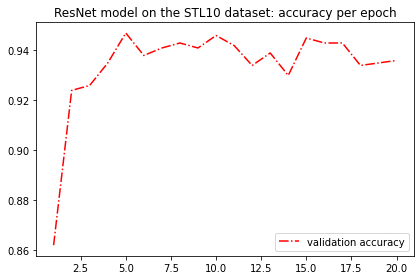

In [8]:
plt.plot(epoch_all, valid_epoch_acc_all, label="validation accuracy", color="red", linestyle='-.')
#plt.plot(epoch_all, train_epoch_acc_all, label="training accuracy", color="blue",linestyle='-.')
plt.title("ResNet model on the STL10 dataset: accuracy per epoch")
plt.legend()
plt.tight_layout()
plt.show()

# Test of the model

We finally implement a test of the model accuracy, on the test dataset, that has not been used in the model training.

In [10]:
# We test our best model (the one with the lowest validation loss)
model.load_state_dict(torch.load('model_stl10.pt'))


# To keep track of test loss and accuracy
test_loss = 0.0
test_running_corrects = 0


model.eval()
for images, labels in testloader:
    # move tensors to GPU if CUDA is available
    images, labels = images.to(device), labels.to(device)
    # forward pass: compute predicted outputs by passing images to the model
    output = model.forward(images)
    # calculate the batch loss
    loss = criterion(output, labels)
    # update average test loss 
    test_loss += loss.item()*images.size(0)
    # to calculate the test accuracy later: 
    # take as prediction the label with highest output (highest probability)
    _, pred = torch.max(output, 1)
    # total number of correct predictions
    test_running_corrects += torch.sum(pred == labels)


# calculate average loss
test_loss = test_loss/len(testloader.sampler)
    
# claculate accuracy
test_epoch_acc = test_running_corrects.double() / len(testloader.sampler)
        
# print training/validation statistics 
print('\tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(
    test_loss,test_epoch_acc))

	Test Loss: 0.156733 	Test Accuracy: 0.948625


We finally get a **94.9\%** test accuracy of our model !